# Spn Density Analysis

In [2]:
pkgs <- c('tidyverse','data.table','ggplot2','plotly','RJSplot')
suppressPackageStartupMessages(sapply(pkgs,require, character.only = T))

tidyverse data.table    ggplot2     plotly    RJSplot 
      TRUE       TRUE       TRUE       TRUE       TRUE

In [6]:
# Data
data <- fread('../../data//raw_data//MIXED//EHPC_Density_Data_12MARCH2020.tsv',data.table = F)
data = data %>% column_to_rownames('sample_id')
tables_rjs(data, jupyter = TRUE)

Filters:
- remove: study = "Gates_Reproducibility","NewStrains" (due to incomplete data, no data of Spn- volunteers)
- remove: re-challenge samples
- select: innoculation_serotype = "6B"
- remove: virus

In [7]:
data = data %>% filter(study != 'Gates_Reproducibility',
                       study != 'NewStrains',
                       inoculation_serotype == "6B") %>% 
                select(-virus) %>%
                mutate(timepoint = as.numeric(gsub('D','',timepoint)))
data = data[-grep("R",data$volunteer_id),]
tables_rjs(data,jupyter = T)

# Spn Density Profiles

Plot the spn density profile of each volunteer over time:

Warning message:
“Removed 288 row(s) containing missing values (geom_path).”


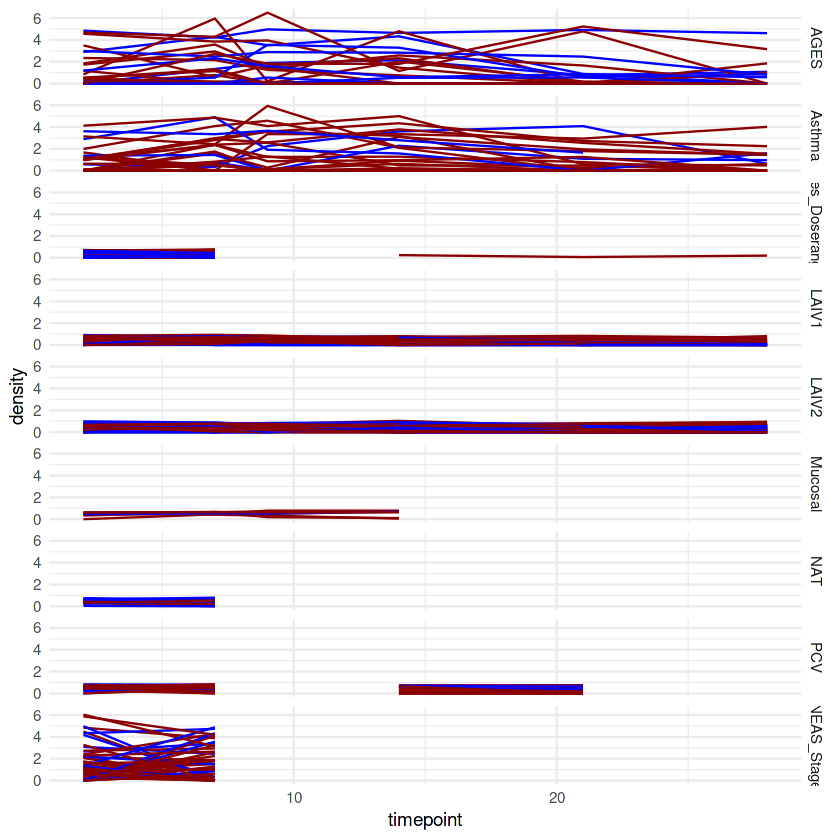

In [23]:
data %>% filter(carriage == 'POS') %>%
    mutate(density = log10(density + 1)) %>%
    ggplot(aes(timepoint, density, group = volunteer_id, col = sex)) + geom_line(show.legend = F) +
    facet_grid(study~.) + scale_colour_manual(values = c('darkred','blue')) + 
    theme_minimal()

The density range in y-axis seems to be very different between studies. How to deal with this in order to use all data to cluster the volunteers (create profiles)? 

# Exploring the Relationship between Carriage and Sex

Number of carriage +/- volunteers by sex in each study:

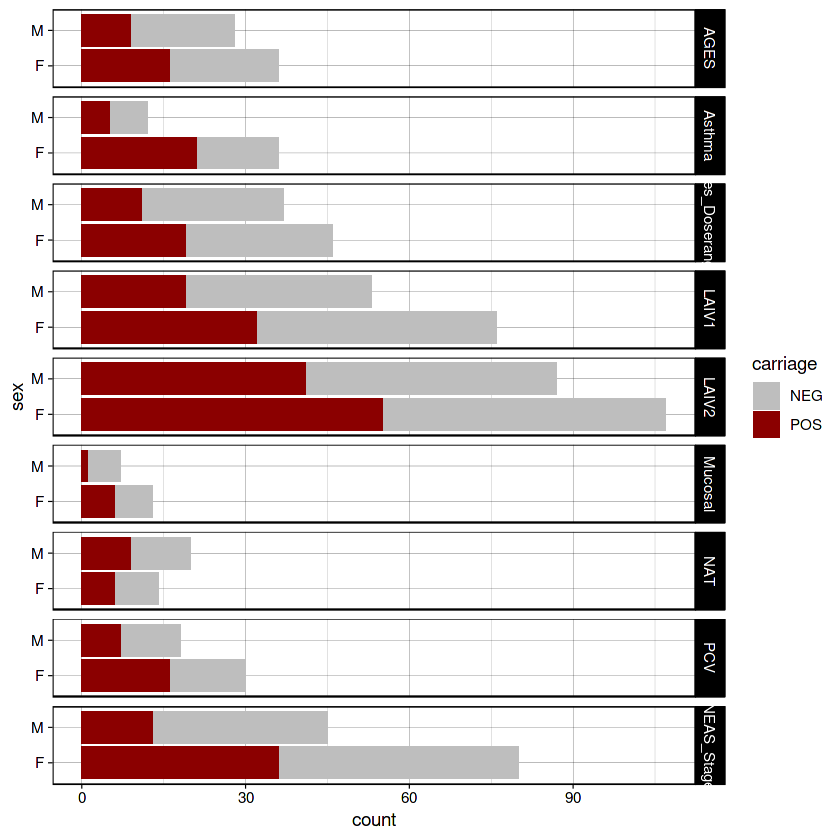

In [28]:
data %>% filter(!duplicated(volunteer_id)) %>%
    ggplot(aes(sex, fill = carriage)) + geom_bar(stat = 'count') + 
    facet_grid(study~.) + theme_linedraw() + coord_flip() +
    scale_fill_manual(values = c('grey','darkred'))

In [29]:
spn_summary_bySexStudy = data %>% filter(!duplicated(volunteer_id)) %>% 
    group_by(study,sex,carriage) %>% summarize(group_count = n()) %>%
    group_by(study, sex) %>% mutate(study_count = sum(group_count), freq = group_count/study_count)
tables_rjs(spn_summary_bySexStudy, jupyter = TRUE)

`summarise()` has grouped output by 'study', 'sex'. You can override using the `.groups` argument.



Spn+/- ratio by sex for each study:

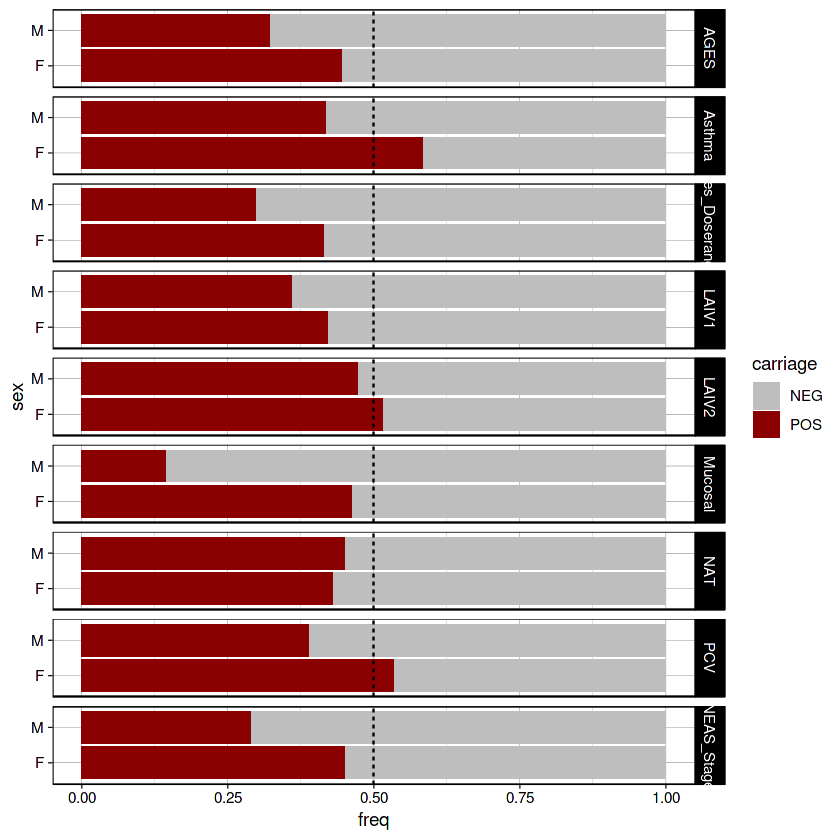

In [30]:
spn_summary_bySexStudy %>% ggplot(aes(sex, freq, fill = carriage)) + geom_bar(stat = 'identity') + 
    facet_grid(study ~.) + geom_hline(yintercept = .5, linetype = 'dashed') +
    theme_linedraw() + scale_fill_manual(values = c('grey','darkred')) + coord_flip()

- Almost in all studies the incidence of developing carriage is higher in women. Why?
- The exception is the NAT study. Why?
- The overall prob. of developing carriage is lower than random $(p \leq 0.5)$, with the exception for women in the studies __Asthma__, __LAIV2__ and __PCV__

## Test for association between sex and carriage 
Given that both sex and carriage are categorical variables, we can use a Chi-square test of independence to determine if there is a statistically significant association between the variables. 
- __$H_0$: Null Hypothesis__: sex and carriage are independent
- __$H_1$: Alternative Hypothesis__: sex and carriage are *not* independent

### $\chi^2$ Test
Formula to calculate the Chi-Square test statistics $\chi^2$:
$$\chi^2 = \sum(O - E)^2 / E$$
+ $O$: observed value
+ $E$: expected value  
  
  
If the *p-value* that corresponds to the test statistic $\chi^2$ with $(n_{rows}-1) * (n_{cols} - 1)$ degrees of freedom is less than your chosen significance level then you can reject the null hypothesis.

#### $\chi^2$ test on overall data
Contigency table:

In [31]:
contigency_table = with(data, table(sex, carriage))
contigency_table

   carriage
sex  NEG  POS
  F 1386 1242
  M 1152  690

Perform Chi-Square Test of Independence

In [32]:
chi.res = chisq.test(contigency_table)
chi.res


	Pearson's Chi-squared test with Yates' continuity correction

data:  contigency_table
X-squared = 41.992, df = 1, p-value = 9.167e-11


#### $\chi^2$ test for each study

In [33]:
contigency_studies <- lapply(split(data, data$study), function(df) table(df$sex, df$carriage))
chi.res = lapply(contigency_studies, chisq.test)
chi.res.df = lapply(chi.res, function(test) data.frame(chi_square = test$statistic, pval = test$p.value)) %>%
       Reduce(rbind, .)
rownames(chi.res.df) <- names(chi.res)
chi.res.df$padj <- p.adjust(chi.res.df$pval)
chi.res.df

,chi_square,pval,padj
,<dbl>,<dbl>,<dbl>
AGES,5.50203772,1.899433e-02,0.1139659643
Asthma,5.38927739,2.026086e-02,0.1139659643
Gates_Doseranging,6.64906749,9.920773e-03,0.0694454132
LAIV1,2.81139174,9.359714e-02,0.2807914321
LAIV2,1.93776148,1.639118e-01,0.3278235903
Mucosal,10.82638973,1.000636e-03,0.0080050847
NAT,0.02563492,8.727951e-01,0.8727951409
PCV,5.07918841,2.421470e-02,0.1139659643
SNEAS_Stage2,18.14945699,2.042277e-05,0.0001838049


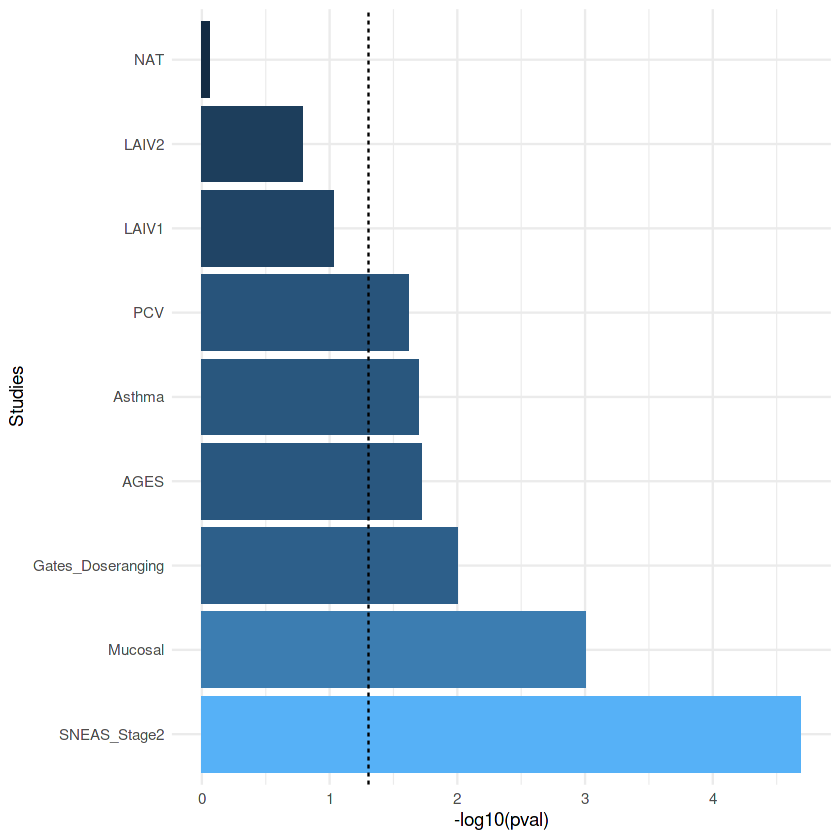

In [34]:
chi.res.df %>% rownames_to_column('study') %>% 
    ggplot(aes(-log10(pval), reorder(study, pval), fill = -log10(pval))) + geom_bar(stat = "identity", show.legend = F) +
    theme_minimal()  + geom_vline(xintercept = -log10(0.05), linetype = 'dashed') + labs(y = 'Studies')

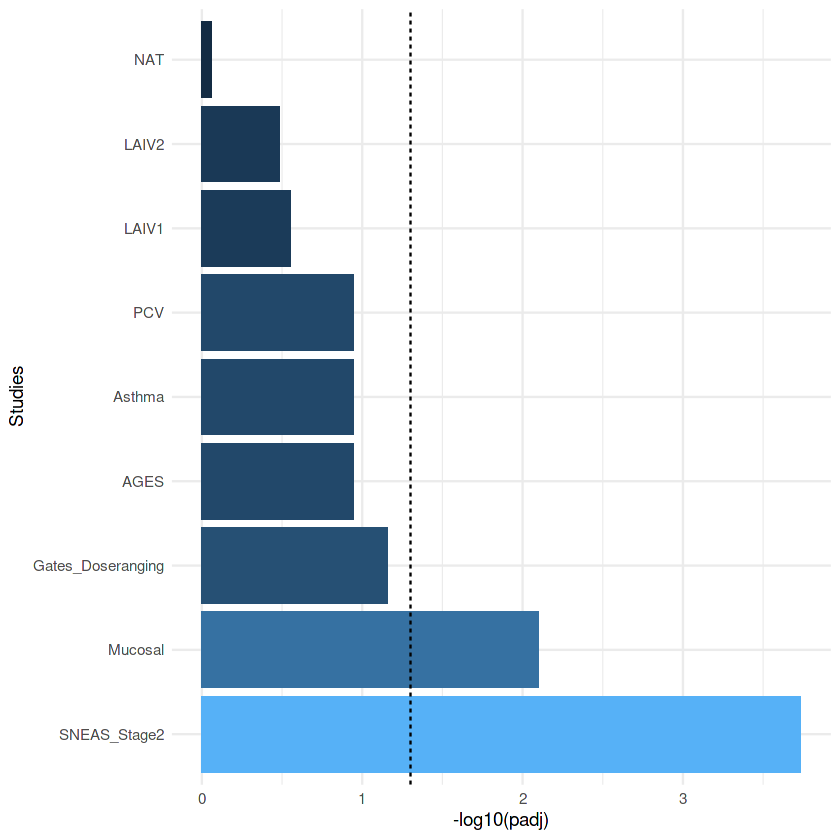

In [35]:
chi.res.df %>% rownames_to_column('study') %>% 
    ggplot(aes(-log10(padj), reorder(study, padj), fill = -log10(padj))) + geom_bar(stat = "identity", show.legend = F) +
    theme_minimal()  + geom_vline(xintercept = -log10(0.05), linetype = 'dashed') + labs(y = 'Studies')

# 2do
- Meta-analysis of studies' probabilities

- color lines by sex
- Cluster density profiles (overall & by sex) 